# Module 2: Conditional Generative Adversarial Networks
(Link to paper: https://arxiv.org/abs/1411.1784)In Conditional GANs, we feed a 'condition' to both the generator and discriminator during training. This will allow us to generate images fulfilling a condition, by feeding the condition to the generator, along with the random noise.We will use MNIST data for this experiment. We will try to condition the network using the class labels of MNIST data. Thus we should be able to generate images from a particular class.

In [1]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda')
%matplotlib inline

In [2]:
mb_size = 64
Z_dim = 100
X_dim = 784
y_dim = 10
h_dim = 128
lr = 1e-3

In [3]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    vec = torch.randn(*size) * xavier_stddev
    vec = vec.to(device)
    vec.requires_grad = True
    return vec

 We will feed the condition as a 'one hot vector encoding' of the class label. The functions below load the MNIST dataset and convert the label into a one hot encoded vector.

In [4]:
dataroot = './data'
# load the dataset
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,), (1,))])

trainset = torchvision.datasets.MNIST(root=dataroot, train=True, download=False,transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size, shuffle=True, num_workers=2)

# One-hot encoding of the class labels 
classes = ('0','1','2','3','4','5','6','7','8','9')
def onehotencoder(x):
    y = np.zeros((x.numpy().shape[0],10))
    for i in range(x.numpy().shape[0]):
        y[i,x[i]] = 1
    return y

def mnist_next(dataiter):

    try:
        images, labels = dataiter.next()
        labels = onehotencoder(labels)
        images = images.view(images.numpy().shape[0],28*28)
    except:
        dataiter = iter(trainloader)
        images, labels = dataiter.next()
        labels = onehotencoder(labels)
        images = images.view(images.numpy().shape[0],28*28)
    return images.numpy(), labels

def initialize_loader(trainset):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                          shuffle=True, num_workers=2)
    dataiter = iter(trainloader)
    return dataiter

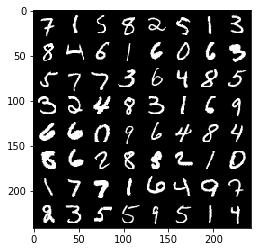

In [5]:
# print some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
img = torchvision.utils.make_grid(images)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

 In order to pass the condition to the generator and discriminator, we have to represent them in a 'joint vector representation'. For our joint vector representation, we will concatenate the one-hot encoded vector with the noise vector.

In [6]:
""" ==================== GENERATOR ======================== """

Wzh = xavier_init(size=[Z_dim + y_dim, h_dim])
Whx = xavier_init(size=[h_dim, X_dim])

bzvar = torch.zeros(h_dim)
bhvar = torch.zeros(X_dim)

bzvar = bzvar.to(device)
bhvar = bhvar.to(device)

bzh = Variable(bzvar, requires_grad=True)
bhx = Variable(bhvar, requires_grad=True)
G_params = [Wzh, bzh, Whx, bhx]

In [7]:
def G(z, c):
    inputs = torch.cat([z, c], 1)
    h = nn.relu(torch.mm(inputs, Wzh) + bzh.repeat(inputs.size(0), 1))
    X = nn.sigmoid(torch.mm(h, Whx) + bhx.repeat(h.size(0), 1))
    return X

 Similarly, for the discriminator, we will concatenate the one hot encoded vectors with the flattened image to get the joint vector representation.

In [8]:
""" ==================== DISCRIMINATOR ======================== """

Wxh = xavier_init(size=[X_dim + y_dim, h_dim])
Why = xavier_init(size=[h_dim, 1])
bxvar = torch.zeros(h_dim)
bhvar = torch.zeros(1)
bxvar = bxvar.to(device)
bhvar = bhvar.to(device)
    
bxh = Variable(bxvar, requires_grad=True)
bhy = Variable(bhvar, requires_grad=True)
D_params = [Wxh, bxh, Why, bhy]

In [9]:
def D(X, c):
    inputs = torch.cat([X, c], 1)
    h = nn.relu(torch.mm(inputs, Wxh) + bxh.repeat(inputs.size(0), 1))
    y = nn.sigmoid(torch.mm(h, Why) + bhy.repeat(h.size(0), 1))
    return y 

 Let us extract the parameters for training and create the ADAM solvers. 

In [10]:
params = G_params + D_params
def reset_grad():
    for p in params:
        p.grad.data.zero_()

In [11]:
G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)

ones_label = torch.ones(mb_size)
zeros_label = torch.zeros(mb_size)

ones_label = ones_label.to(device)
zeros_label = zeros_label.to(device)

 Here, we do the actual training. It is similar to the vanilla GAN network, except that we concatenate the one-hot encoded labels to the inputs of both networks.

In [12]:
dataiter = initialize_loader(trainset)

for it in range(10000):
    # Sample data
    z =torch.randn(mb_size, Z_dim)
    X, c = mnist_next(dataiter)
    if X.shape[0]!=mb_size:
        dataiter = initialize_loader(trainset)
        X,c = mnist_next(dataiter)
    X = torch.from_numpy(X)
    c = torch.from_numpy(c.astype('float32'))
    
    z = z.to(device)
    X = X.to(device)
    c = c.to(device)

    # Dicriminator forward-loss-backward-update
    G_sample = G(z, c)
    D_real = D(X, c)
    D_fake = D(G_sample, c)

    D_loss_real = nn.binary_cross_entropy(D_real, ones_label)
    D_loss_fake = nn.binary_cross_entropy(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake

    D_loss.backward()
    D_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Generator forward-loss-backward-update
    z = torch.randn(mb_size, Z_dim)
    z = z.to(device)

    G_sample = G(z, c)
    D_fake = D(G_sample, c)

    G_loss = nn.binary_cross_entropy(D_fake, ones_label)

    G_loss.backward()
    G_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy()))

/home/avideep/.local/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/avideep/.local/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Iter-0; D_loss: 1.424142599105835; G_loss: 1.9514816999435425
Iter-1000; D_loss: 0.01129464153200388; G_loss: 10.665889739990234
Iter-2000; D_loss: 0.008572726510465145; G_loss: 7.074395179748535
Iter-3000; D_loss: 0.016542496159672737; G_loss: 5.956159591674805
Iter-4000; D_loss: 0.03160443156957626; G_loss: 8.920459747314453
Iter-5000; D_loss: 0.04429059103131294; G_loss: 6.4162516593933105
Iter-6000; D_loss: 0.18768799304962158; G_loss: 5.709718704223633
Iter-7000; D_loss: 0.15383625030517578; G_loss: 5.109402656555176
Iter-8000; D_loss: 0.19030681252479553; G_loss: 4.7405476570129395
Iter-9000; D_loss: 0.5339535474777222; G_loss: 4.039379596710205


Let us see the images produced by the C-GAN. By changing the condition vector, we can generate images from different classes. 

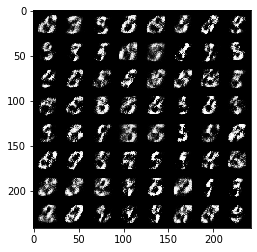

In [13]:
z = torch.randn(mb_size, Z_dim)
discr_codes = torch.zeros(64,10)
z = z.to(device)
discr_codes = discr_codes.to(device)


discr_codes[:,5] = 1 
samples = G(z,discr_codes)
samples = samples.cpu()
img = samples.data
img = img.view([64,1,28,28])
img = torchvision.utils.make_grid(img)
img = img.permute(1,2,0)
plt.imshow(img.numpy())

## Points to ponder:
<ol>
<li> What do the noise vectors mean? 
<li> What happens when we gradually change the noise vectors? </li>
<li> How does the plot of error compare to vanilla GAN?</lo>
</ol>